

# <center>VMAT Optimization</center>

Volumetric Modulated Arc Therapy (VMAT) has increasingly become the preferred treatment method for many disease sites, primarily due to its fast plan delivery and dose distribution comparable to that of IMRT. However, the optimization of numerous apertures and their corresponding monitor units results in challenging large-scale non-convex optimization problems. As a result, researchers often resort to computationally efficient heuristic methods to solve these issues. Having a globally optimal solution as a benchmark can assist with the development and validation of new VMAT algorithms.

The VMAT problem can be formulated as a Mixed Integer Programming (MIP) problem, solvable to global optimality for small-to-medium sized problems. To construct the MIP problem, we initially need to formulate a conventional IMRT optimization problem (please refer to [basic_tutorial](http://localhost:8888/notebooks/examples/1_basic_tutorial.ipynb)). Subsequently, for each beamlet $i$, we introduce a binary variable $z_i$ that signifies whether beamlet $i$ is open (1) or closed (0). We also introduce integer variables $l_{br}/r_{br}$ to denote the position of the left/right leaf of beam $b$ at row $r$. Then, we integrate the following constraints (for a detailed explanation, please refer to Dursun et al 2021): "


$\quad r_{b_i t_i} - c_i\times z_i \geq 0  \quad $   ($z_i=0$ if the right leaf covers beamlet i)

$\quad (N+1-c_i )\times z_i+l_{b_{i}t_{i}} \leq N	\quad $ ($z_i=0$ if the left leaf covers beamlet i)


$\quad \sum_{i\in I_{bt}}z_i = r_{bt}-l_{bt} \quad $   ($z_i=1$ if neither left/right leaves cover beamlet i)

$\quad 0 \leq x_i \leq U^μ \times z_i \quad \quad$ ($x_i=0$ if $z_i=0$)


$\quad μ_{b_i} - U^μ \times (1-z_i ) \leq x_i \leq μ_{b_i} \quad $ ($x_i=μ_{b_i}$ if $z_i=1$)


$\quad z_i: binary; l_{b_{i}t_{i}},r_{b_{i}t_{i}}:integer $


Here, $c_i$ is the column number of beamlet $i$, $N$ is the number of columns, $μ_{b}$ is the aperture intensity of beam $b$, $U^μ$ is the upper bound on aperture intensity, and $I_{bt}$ refers to beamlets that correspond to beam $b$ and its row $t$.

**Note:** To adapt the default IMRT optimization problem for the construction of the VMAT MIP problem, we first eliminate the fluence smoothness from the objective function. Furthermore, to keep the VMAT optimization problem computationally manageable, we substitute quadratic functions with their linear counterparts.



In [1]:
import sys
sys.path.append('..\..')

In [2]:
import portpy.photon as pp
import numpy as np
import cvxpy as cp
import os

###  Creating a benchmark VMAT plan on down-sampled data
**Note**: When benchmarking your VMAT algorithm against the globally optimal solution derived from MIP, it's crucial to use downsampled data in both the MIP and your algorithm. This ensures a fair comparison. 

In [3]:
# specify the patient data location.
data_dir = r'../../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# Pick a patient 
data.patient_id = 'Lung_Patient_6'
# Load ct, structure set, beams for the above patient using CT, Structures, and Beams classes
ct = pp.CT(data)
structs = pp.Structures(data)
# generating VMAT plan using all the control points is computationally expensive. We select only 8 equidistant beams to create the benchamrk VMAT plan.
beam_ids = list(np.arange(0,72,10))
beams = pp.Beams(data, beam_ids=beam_ids)

# Pick a protocol
protocol_name = 'Lung_2Gy_30Fx'
# Load clinical criteria for a specified protocol
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)
# Load hyper-parameter values for optimization problem for a specified protocol
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# Create optimization structures (i.e., Rinds) 
structs.create_opt_structures(opt_params=opt_params)
# Load influence matrix
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# create a down-sampled influence matrix
voxel_down_sample_factors = [6, 6, 1]
opt_vox_xyz_res_mm = [ct_res * factor for ct_res, factor in zip(ct.get_ct_res_xyz_mm(), voxel_down_sample_factors)]
beamlet_down_sample_factor = 8
new_beamlet_width_mm = beams.get_finest_beamlet_width() * beamlet_down_sample_factor
new_beamlet_height_mm = beams.get_finest_beamlet_height() * beamlet_down_sample_factor

inf_matrix_db = inf_matrix.create_down_sample(beamlet_width_mm=new_beamlet_width_mm,
                                               beamlet_height_mm=new_beamlet_height_mm,
                                               opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)

# Create a plan 
my_plan = pp.Plan(ct = ct, structs = structs, beams = beams, inf_matrix = inf_matrix_db, clinical_criteria=clinical_criteria)

# remove smoothness objective
for i in range(len(opt_params['objective_functions'])):
    if opt_params['objective_functions'][i]['type'] == 'smoothness-quadratic':
        opt_params['objective_functions'][i]['weight'] = 0

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
CT voxel resolution in xyz is [0.98, 0.98, 3] mm
Data optimization voxel resolution in xyz is [2.93, 2.93, 3] mm
Down Sampled optimization voxel resolution in xyz is [5.88, 5.88, 3] mm
reindexing voxels...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
parsing influence matrix for beam 7
creating influence matrix for down sample voxels..


In [5]:
# create optimization problem
opt = pp.Optimization(my_plan, opt_params=opt_params)
opt.create_cvxpy_problem()

# replace the quadratic objective functions with the linear ones
obj_funcs = opt_params['objective_functions'] if 'objective_functions' in opt_params else []

A = inf_matrix_db.A
num_fractions = clinical_criteria.get_num_of_fractions()
st = inf_matrix_db
x = opt.vars['x']
d = None

# Construct optimization problem

opt.obj = [] # Remove all previous objective functions

# Generating new linear objective functions
print('Objective Start')
for i in range(len(obj_funcs)):
    if obj_funcs[i]['type'] == 'quadratic-overdose':
        if obj_funcs[i]['structure_name'] in my_plan.structures.get_structures():
            struct = obj_funcs[i]['structure_name']
            dose_gy = opt.get_num(obj_funcs[i]['dose_gy']) / clinical_criteria.get_num_of_fractions()
            dO = cp.Variable(len(st.get_opt_voxels_idx(struct)), pos=True)
            opt.obj += [(1 / len(st.get_opt_voxels_idx(struct))) *
                    (obj_funcs[i]['weight'] * cp.sum(dO))]
            opt.constraints += [A[st.get_opt_voxels_idx(struct), :] @ x <= dose_gy + dO]
    elif obj_funcs[i]['type'] == 'quadratic-underdose':
        if obj_funcs[i]['structure_name'] in my_plan.structures.get_structures():
            struct = obj_funcs[i]['structure_name']
            dose_gy = opt.get_num(obj_funcs[i]['dose_gy']) / clinical_criteria.get_num_of_fractions()
            dU = cp.Variable(len(st.get_opt_voxels_idx(struct)), pos=True)
            opt.obj += [(1 / len(st.get_opt_voxels_idx(struct))) *
                    (obj_funcs[i]['weight'] * cp.sum(dU))]
            opt.constraints += [A[st.get_opt_voxels_idx(struct), :] @ x >= dose_gy - dU]
    elif obj_funcs[i]['type'] == 'quadratic':
        if obj_funcs[i]['structure_name'] in my_plan.structures.get_structures():
            struct = obj_funcs[i]['structure_name']
            opt.obj += [(1 / len(st.get_opt_voxels_idx(struct))) * (
                    obj_funcs[i]['weight'] * cp.sum(A[st.get_opt_voxels_idx(struct) ,:] @ x))]   

Objective Start


In [7]:
# Creating a map between leaf and beamlet indices for each control point
beam_maps = my_plan.inf_matrix.get_bev_2d_grid(beam_id=my_plan.beams.get_all_beam_ids())
vmat_beams = []
for i in range(len(beam_maps)):
    beam_map = beam_maps[i]
    beam_map = beam_map[~np.all(beam_map == -1, axis=1), :]  # remove rows which are not in BEV
    # beam_map = beam_map[:, ~np.all(beam_map == -1, axis=0)]  # remove cols which are not in BEV
    num_rows, num_cols = beam_map.shape

    leaf_idx_beamlet_map = {}
    for j, row in enumerate(beam_map):
        leaf_idx_beamlet_map[j] = row[row >= 0].tolist()
    map_beamlet = {'leaf_idx_beamlet_map': leaf_idx_beamlet_map, 'num_rows': num_rows, 'num_cols': num_cols,
                   'beam_map': beam_map}
    vmat_beams.append(map_beamlet)
total_rows = sum([b['num_rows'] for b in vmat_beams])

In [8]:
# creating new variables for VMAT
lbi = cp.Variable(total_rows, integer=True)
rbi = cp.Variable(total_rows, integer=True)
z = cp.Variable(my_plan.inf_matrix.A.shape[1], boolean=True)
mu = cp.Variable(len(vmat_beams), pos=True)
x = opt.vars['x']
U = 2

# Add geometric constraints (consecutive ones)
leaf_in_prev_beam = 0
for i, beam in enumerate(vmat_beams):
    beam_map = beam['beam_map']
    leaf_idx_beamlet_map = beam['leaf_idx_beamlet_map']

    for leaf in leaf_idx_beamlet_map:
        beamlets_in_leaf = leaf_idx_beamlet_map[leaf]
        c = np.where(np.isin(beam_map, beamlets_in_leaf))
        
        opt.constraints += [rbi[leaf_in_prev_beam + leaf] - cp.multiply(c[1] + 1, z[beamlets_in_leaf]) >= 1]
        opt.constraints += [
            cp.multiply((beam['num_cols'] - c[1]), z[beamlets_in_leaf]) + lbi[leaf_in_prev_beam + leaf] <= beam[
                'num_cols']]
        opt.constraints += [cp.sum([z[b_i] for b_i in beamlets_in_leaf]) == rbi[leaf_in_prev_beam + leaf] - lbi[
            leaf_in_prev_beam + leaf] - 1]
        opt.constraints += [rbi[leaf_in_prev_beam + leaf] <= beam['num_cols']]
        
        opt.constraints += [x[beamlets_in_leaf] <= U * z[beamlets_in_leaf]]
        opt.constraints += [mu[i] - U * (1 - z[beamlets_in_leaf]) <= x[beamlets_in_leaf]]
        opt.constraints += [x[beamlets_in_leaf] <= mu[i]]

    leaf_in_prev_beam = leaf_in_prev_beam + len(leaf_idx_beamlet_map)
    # bound constraints
    opt.constraints += [mu[i] <= U]
opt.constraints += [lbi >= 0]
opt.constraints += [rbi >= 0]
    

In [ ]:
sol = opt.solve(solver=cp.MOSEK, verbose=False) # optimize the problem
# save the optimized solution for all the variables in solution dictionary
sol['MU'] = mu.value
sol['left_leaf_pos'] = lbi.value
sol['right_leaf_pos'] = rbi.value

<Axes: title={'center': 'Axial View - Slice #: 60'}>

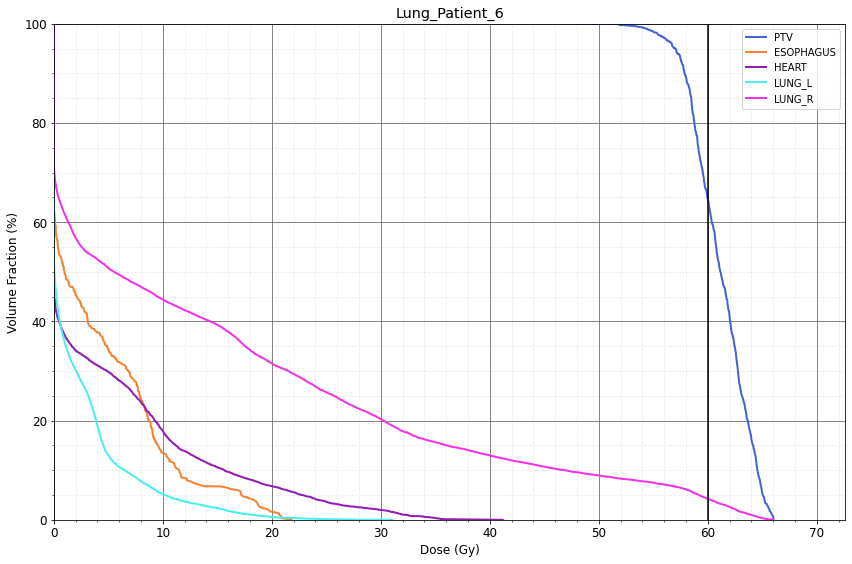

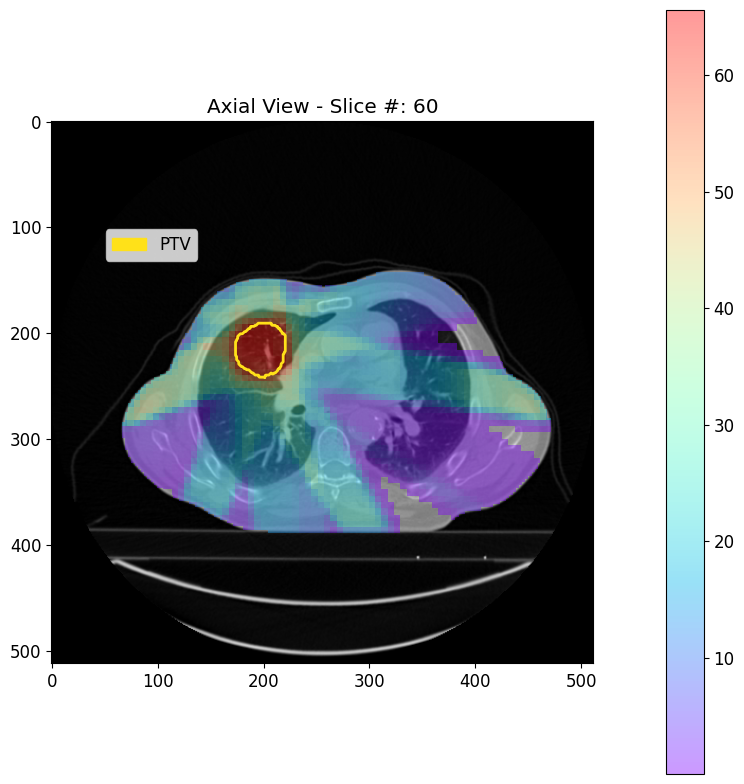

In [11]:
# plot dvh for the structures in the given list. Default dose_1d is in Gy and volume is in relative scale(%).
struct_names = ['PTV', 'ESOPHAGUS', 'HEART','LUNG_L','LUNG_R']
pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names, title=patient_id)

# plot 2d axial slice for the given solution and display the structures contours on the slice
pp.Visualization.plot_2d_slice(my_plan=my_plan, sol=sol, slice_num=60, struct_names=['PTV'])